# ***Predicting Proposal Success - 03 - Feature Engineering***

**Purpose:** Prepare the proposals data for the two modelling problems that were identified during EDA: RFS and Non-RFS.
The modelling that this data will be supporting is a one-off exploration of factors influencing proposal outcomes, so the below is not built in a pipeline fashion

**Next Steps:** Modelling for ALL and RFS proposals

# **File Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

We are importing the output from 'Predicting Proposal Success - 02 - EDA' which can be found here: https://colab.research.google.com/drive/1GoAupEBPMN40NJz67RT4ppdBMWjcIdPu?usp=sharing

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   prop = pd.read_csv(io.BytesIO(file_content))
   prop.set_index(prop.columns[0], inplace=True)

print(prop.shape)

Saving 2.1 EDA Output.csv to 2.1 EDA Output (7).csv
(3052, 26)


In [ ]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3052 entries, 0 to 3151
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   proposal_num     3048 non-null   object 
 1   registry_region  3052 non-null   object 
 2   sow              3052 non-null   object 
 3   rfp              3052 non-null   int64  
 4   units_orig       2845 non-null   object 
 5   storeys_orig     2769 non-null   object 
 6   townhouse_orig   2688 non-null   object 
 7   parking_orig     2709 non-null   object 
 8   prev_rfs         3052 non-null   object 
 9   reminder         3048 non-null   object 
 10  fee_probable     3052 non-null   float64
 11  issued_date      3052 non-null   object 
 12  outcome          3052 non-null   int64  
 13  prev_wins        3052 non-null   float64
 14  townhouse_flag   3052 non-null   int64  
 15  storeys          1086 non-null   float64
 16  comm_flag        3052 non-null   float64
 17  comm_units       19

In [ ]:
#We'll remove the columns that were not identified as significant during EDA
prop = prop[['region', 'prev_rfs', 'reminder', 'fee_probable', 'outcome', 'project_type', 'building_type', 'units','sow']]

In [ ]:
prop.head()

,region,prev_rfs,reminder,fee_probable,outcome,project_type,building_type,units,sow
Unnamed: 0,,,,,,,,,
0,TOR,Yes,No,2795.0,1,RFS,unknown,NaN,Update RFS
1,PC,No,No,2500.0,0,RFS,residential,39.0,Class 2 RFS
2,TOR,Yes,Yes,3795.0,1,RFS,highrise,46.0,Update RFS
3,Unknown,Yes,No,1508.0,1,RFS,unknown,NaN,Class 3 RFS
4,TOR,Yes,No,5825.0,0,RFS,highrise,320.0,Class 2 RFS


# **Classifier: outcome**

outcome is the the final classification that we will be looking to predict for both the RFS and ALL models. This column has already been cleaned, but lets take a look again just to make sure it is good to go from a modelling perspective

In [ ]:
prop['outcome'].value_counts(dropna=False)

,count
outcome,
1,1553
0,1499


Confirmed that there are no nulls in this column and everything is classified as 0 for loss or 1 for win

# **Non-RFS Model Feature Prep**

This model will be applied across all project types, excluding RFS

There were only three columns that were identified as usable for All projects types:
*   region
*   fee_probable
*   project_type **OR**
*   sow

The project_type vs sow choice will be made when we look at collinearity














In [ ]:
#project_type and sow
all = prop[['region', 'fee_probable', 'project_type', 'outcome', 'sow']]

#remove RFS projects
all = all[all['project_type'] != 'RFS']

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 8 to 3151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        1682 non-null   object 
 1   fee_probable  1682 non-null   float64
 2   project_type  1682 non-null   object 
 3   outcome       1682 non-null   int64  
 4   sow           1682 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 78.8+ KB


In [ ]:
all.head()

,region,fee_probable,project_type,outcome,sow
Unnamed: 0,,,,,
8,EO,8190.0,Other,0,"PA1, C1, PA2"
31,Unknown,1890.0,Other,0,C2 RFS with C3 Fee
32,Unknown,1920.0,Other,0,C2 RFS with C3 Fee
33,Unknown,1770.0,Other,0,C2 RFS with C3 Fee
34,EO,2360.0,Other,0,C2 RFS with C3 Fee


In [ ]:
all = all.reset_index(drop=True)

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        1682 non-null   object 
 1   fee_probable  1682 non-null   float64
 2   project_type  1682 non-null   object 
 3   outcome       1682 non-null   int64  
 4   sow           1682 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 65.8+ KB


**project_type**

In [ ]:
all['project_type'].value_counts(dropna=False)

,count
project_type,
BCA,291
Consult,285
PCA,268
Envelope,204
Other,179
Roofing,153
Mechanical,116
Garage,98
PA & Class 1 RFS,88


During EDA, project_type was found to have impact, but it was also found to be perhaps a bit too high-level. We will be evaluating whether the project_types can be better grouped using the sow column. To this end, we'll start with one-hot encoding both project_type and sow and will revisit this later

In [ ]:
all = pd.get_dummies(all, columns=['project_type'], prefix = 'project_type')

In [ ]:
all.head()

,region,fee_probable,outcome,sow,project_type_BCA,project_type_Consult,project_type_Envelope,project_type_Garage,project_type_Mechanical,project_type_Other,project_type_PA & Class 1 RFS,project_type_PCA,project_type_Roofing
0,EO,8190.0,0,"PA1, C1, PA2",False,False,False,False,False,True,False,False,False
1,Unknown,1890.0,0,C2 RFS with C3 Fee,False,False,False,False,False,True,False,False,False
2,Unknown,1920.0,0,C2 RFS with C3 Fee,False,False,False,False,False,True,False,False,False
3,Unknown,1770.0,0,C2 RFS with C3 Fee,False,False,False,False,False,True,False,False,False
4,EO,2360.0,0,C2 RFS with C3 Fee,False,False,False,False,False,True,False,False,False


In [ ]:
all.shape

(1682, 13)

**sow**

In [ ]:
all['sow'].describe()

,sow
count,1682
unique,31
top,Consult
freq,285


In [ ]:
all['sow'].value_counts(dropna=False)

,count
sow,
Consult,285
PCA,268
BCA,258
Roofing,153
Mechanical,116
Envelope,101
Garage,98
PA & Class 1 RFS,88
PPA,52


As per client direction, we will group  Renovation, Windows, Landscaping, Sealants, Stairs, and Doors into a revised 'Renovation' category

In [ ]:
all.loc[all['sow'].isin(['Windows', 'Landscaping', 'Sealants', 'Stairs', 'Doors']), 'sow'] = 'Renovation'

We'll group anything remianing that is under 20 instances as 'Other'

In [ ]:
counts = all['sow'].value_counts()
mask = all['sow'].isin(counts[counts < 20].index)
all.loc[mask, 'sow'] = 'Other'

In [ ]:
all['sow'].describe()

,sow
count,1682
unique,16
top,Consult
freq,285


Now the column is ready to be made into dummies

In [ ]:
all = pd.get_dummies(all, columns=['sow'], prefix = 'sow')

In [ ]:
all.shape

(1682, 28)

**Region**

This column has already been cleaned since it was grouped from a more detailed indicator. We'll check for completeness just in case

In [ ]:
all['region'].value_counts(dropna=False)

,count
region,
Unknown,1091
TOR,241
EO,117
YR,87
PC,54
HUR,42
GH,37
LON,6
GR,4


In [ ]:
#Lets roll the low-count regions into an 'Other' category
all['region'] = all['region'].replace({
    'WIN': 'Other',
    'GR': 'Other',
    'LON': 'Other'
})

In [ ]:
all['region'].value_counts(dropna=False)

,count
region,
Unknown,1091
TOR,241
EO,117
YR,87
PC,54
HUR,42
GH,37
Other,13


Ready for one-hot encoding

In [ ]:
#one-hot encode the region column
all = pd.get_dummies(all, columns=['region'], prefix = 'region')

In [ ]:
all.head()

,fee_probable,outcome,project_type_BCA,project_type_Consult,project_type_Envelope,project_type_Garage,project_type_Mechanical,project_type_Other,project_type_PA & Class 1 RFS,project_type_PCA,...,sow_Roofing,sow_Structural,region_EO,region_GH,region_HUR,region_Other,region_PC,region_TOR,region_Unknown,region_YR
0,8190.0,0,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
1,1890.0,0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1920.0,0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1770.0,0,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2360.0,0,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
all.shape

(1682, 35)

**fee_probable**

In [ ]:
#Let's start by dropping the two rows with nulls in the fee_probable column
all = all.dropna(subset=['fee_probable'])

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fee_probable                   1682 non-null   float64
 1   outcome                        1682 non-null   int64  
 2   project_type_BCA               1682 non-null   bool   
 3   project_type_Consult           1682 non-null   bool   
 4   project_type_Envelope          1682 non-null   bool   
 5   project_type_Garage            1682 non-null   bool   
 6   project_type_Mechanical        1682 non-null   bool   
 7   project_type_Other             1682 non-null   bool   
 8   project_type_PA & Class 1 RFS  1682 non-null   bool   
 9   project_type_PCA               1682 non-null   bool   
 10  project_type_Roofing           1682 non-null   bool   
 11  sow_BCA                        1682 non-null   bool   
 12  sow_BCA & RFS                  1682 non-null   b

In [ ]:
all['fee_probable'].describe()

,fee_probable
count,1682.000000
mean,17929.524376
std,49242.396321
min,175.000000
25%,2992.000000
50%,5495.000000
75%,12000.000000
max,651000.000000


The distribution of this column is extremely left-skewed with a high number of outliers on the right. During EDA the attempts to describe the shape were not successful, so we will have to bucket the values

We need to do this transformation after splitting the dataset into train/test. This will be done in the next section

# **Non-RFS Model Transformations**

The ALL model data is ready for transformations now

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fee_probable                   1682 non-null   float64
 1   outcome                        1682 non-null   int64  
 2   project_type_BCA               1682 non-null   bool   
 3   project_type_Consult           1682 non-null   bool   
 4   project_type_Envelope          1682 non-null   bool   
 5   project_type_Garage            1682 non-null   bool   
 6   project_type_Mechanical        1682 non-null   bool   
 7   project_type_Other             1682 non-null   bool   
 8   project_type_PA & Class 1 RFS  1682 non-null   bool   
 9   project_type_PCA               1682 non-null   bool   
 10  project_type_Roofing           1682 non-null   bool   
 11  sow_BCA                        1682 non-null   bool   
 12  sow_BCA & RFS                  1682 non-null   b

train-test-split

In [ ]:
X = all.drop('outcome', axis=1)
y = all['outcome']

In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=37)

**probable_ fee**

Given the extreme left skew of our data, we're going to use log-binning which does not need the data to be standardized

In [ ]:
X_train_all['log_fee'] = np.log1p(X_train_all['fee_probable'])

def log_bins(data, num_bins):
    min_val = data.min() + 1
    max_val = data.max()
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
    return pd.cut(data, bins=bin_edges, labels=False)

X_train_all['log_fee_binned'] = log_bins(X_train_all['log_fee'], num_bins=10)

In [ ]:
pd.pivot_table(X_train_all, index='log_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
log_fee_binned,,,
0.0,495.0,825.0,20
1.0,880.0,1500.0,81
2.0,1550.0,2925.0,216
3.0,2950.0,6000.0,430
4.0,6100.0,13095.0,283
5.0,13290.0,30760.0,161
6.0,31000.0,75250.0,76
7.0,78570.0,210400.0,49


Text(0.5, 1.0, 'Distribution of Fee Bins')

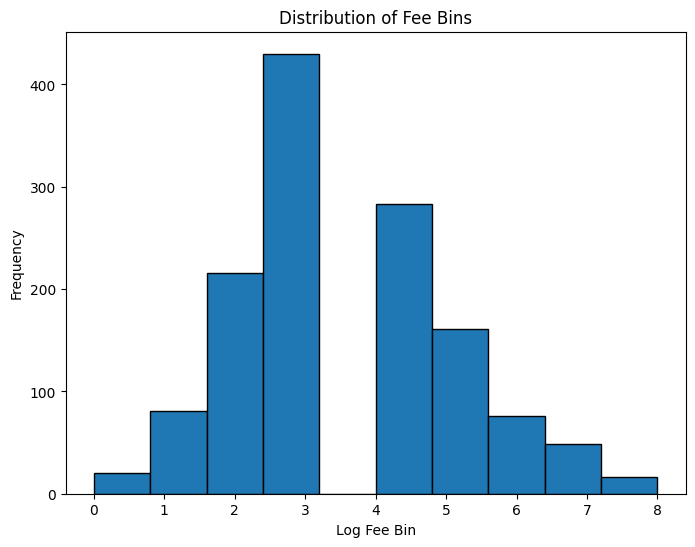

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(X_train_all['log_fee_binned'], bins=10, edgecolor='k')
plt.xlabel('Log Fee Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Fee Bins')

The data is bunched to the left without much discernable groupings in the numbers, so we're going to try equal frequency binning

In [ ]:
X_train_all['equal_fee_binned'], bin_edges = pd.qcut(X_train_all['fee_probable'], q=10, labels=False, retbins=True)

In [ ]:
pd.pivot_table(X_train_all, index='equal_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
equal_fee_binned,,,
0,175.0,1695.0,141
1,1700.0,2650.0,128
2,2685.0,3190.0,135
3,3195.0,4150.0,135
4,4190.0,5400.0,135
5,5490.0,6750.0,133
6,6790.0,9720.0,134
7,9750.0,15095.0,135


The results from equal frequency binning seem more fitting and explainable, so let's apply this to out train and test data

In [ ]:
X_train_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345 entries, 38 to 363
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fee_probable                   1345 non-null   float64
 1   project_type_BCA               1345 non-null   bool   
 2   project_type_Consult           1345 non-null   bool   
 3   project_type_Envelope          1345 non-null   bool   
 4   project_type_Garage            1345 non-null   bool   
 5   project_type_Mechanical        1345 non-null   bool   
 6   project_type_Other             1345 non-null   bool   
 7   project_type_PA & Class 1 RFS  1345 non-null   bool   
 8   project_type_PCA               1345 non-null   bool   
 9   project_type_Roofing           1345 non-null   bool   
 10  sow_BCA                        1345 non-null   bool   
 11  sow_BCA & RFS                  1345 non-null   bool   
 12  sow_Balcony                    1345 non-null   bool  

In [ ]:
#drop fee_probable, log_fee and log_fee_binned from X_train
X_train_all = X_train_all.drop(['fee_probable', 'log_fee', 'log_fee_binned'], axis=1)

In [ ]:
#Apply the binning to X_test
X_test_all['equal_fee_binned'] = pd.cut(X_test_all['fee_probable'], bins=bin_edges, labels=False, include_lowest=True)

In [ ]:
#This matches our training bins, so we can now drop fee_probable
pd.pivot_table(X_test_all, index='equal_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
equal_fee_binned,,,
0,350.0,1695.0,25
1,1770.0,2650.0,33
2,2690.0,3100.0,28
3,3195.0,4095.0,34
4,4200.0,5250.0,41
5,5450.0,6590.0,24
6,6790.0,9590.0,51
7,9745.0,15000.0,36


In [ ]:
X_test_all = X_test_all.drop('fee_probable', axis=1)

In [ ]:
#convert the fee bins to dummy variables
X_train_all = pd.get_dummies(X_train_all, columns=['equal_fee_binned'], prefix = 'fee')
X_test_all = pd.get_dummies(X_test_all, columns=['equal_fee_binned'], prefix = 'fee')

In [ ]:
X_train_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345 entries, 38 to 363
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   project_type_BCA               1345 non-null   bool 
 1   project_type_Consult           1345 non-null   bool 
 2   project_type_Envelope          1345 non-null   bool 
 3   project_type_Garage            1345 non-null   bool 
 4   project_type_Mechanical        1345 non-null   bool 
 5   project_type_Other             1345 non-null   bool 
 6   project_type_PA & Class 1 RFS  1345 non-null   bool 
 7   project_type_PCA               1345 non-null   bool 
 8   project_type_Roofing           1345 non-null   bool 
 9   sow_BCA                        1345 non-null   bool 
 10  sow_BCA & RFS                  1345 non-null   bool 
 11  sow_Balcony                    1345 non-null   bool 
 12  sow_Consult                    1345 non-null   bool 
 13  sow_Envelope           

In [ ]:
X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337 entries, 233 to 1285
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   project_type_BCA               337 non-null    bool 
 1   project_type_Consult           337 non-null    bool 
 2   project_type_Envelope          337 non-null    bool 
 3   project_type_Garage            337 non-null    bool 
 4   project_type_Mechanical        337 non-null    bool 
 5   project_type_Other             337 non-null    bool 
 6   project_type_PA & Class 1 RFS  337 non-null    bool 
 7   project_type_PCA               337 non-null    bool 
 8   project_type_Roofing           337 non-null    bool 
 9   sow_BCA                        337 non-null    bool 
 10  sow_BCA & RFS                  337 non-null    bool 
 11  sow_Balcony                    337 non-null    bool 
 12  sow_Consult                    337 non-null    bool 
 13  sow_Envelope          

The ALL data is now ready for modelling

# **RFS Model Feature Prep**

The model will be applied to proposals for Reserve Fund Studies. The data is consistently much more complete for this project type, so there are more features that will be included
*   region
*   fee_probable
*   sow
*   prev_rfs
*   reminder
*   building_type
*   units

project_type has been excluded from this list since it would be RFS for all records


**SOW**

This is the column we'll use to identify projects that are RFSs

In [ ]:
#From the below list we'll be using Class 2 RFS, Update RFS, PA & Class 1 RFS, Class 1 RFS and Class 3 RFS
prop['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,844
Update RFS,457
Consult,285
PCA,268
BCA,258
Roofing,153
Mechanical,116
Envelope,101
Garage,98


In [ ]:
#create a new df rfs with all rfs proposals
rfs = prop[prop['sow'].isin(['Class 2 RFS', 'Update RFS', 'Class 1 RFS', 'Class 3 RFS'])]

In [ ]:
rfs['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,844
Update RFS,457
Class 1 RFS,53
Class 3 RFS,16


In [ ]:
#We are left with 1458 records, and can already see that units is the only column where we will have nulls to deal with
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 3150
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         1370 non-null   object 
 1   prev_rfs       1370 non-null   object 
 2   reminder       1370 non-null   object 
 3   fee_probable   1370 non-null   float64
 4   outcome        1370 non-null   int64  
 5   project_type   1370 non-null   object 
 6   building_type  1370 non-null   object 
 7   units          1245 non-null   float64
 8   sow            1370 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 107.0+ KB


In [ ]:
#We'll convert the sow column to dummies
rfs = pd.get_dummies(rfs, columns=['sow'], prefix = 'sow')

In [ ]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 3150
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           1370 non-null   object 
 1   prev_rfs         1370 non-null   object 
 2   reminder         1370 non-null   object 
 3   fee_probable     1370 non-null   float64
 4   outcome          1370 non-null   int64  
 5   project_type     1370 non-null   object 
 6   building_type    1370 non-null   object 
 7   units            1245 non-null   float64
 8   sow_Class 1 RFS  1370 non-null   bool   
 9   sow_Class 2 RFS  1370 non-null   bool   
 10  sow_Class 3 RFS  1370 non-null   bool   
 11  sow_Update RFS   1370 non-null   bool   
dtypes: bool(4), float64(2), int64(1), object(5)
memory usage: 101.7+ KB


***region***

We already checked this one for the ALL model data,

In [ ]:
rfs['region'].value_counts(dropna=False)

,count
region,
TOR,528
EO,208
HUR,201
YR,175
PC,120
Unknown,66
GH,54
GR,8
LON,7


In [ ]:
#we'll apply the same goruping we did to the ALL data
rfs['region'] = rfs['region'].replace({
    'WIN': 'Other',
    'GR': 'Other',
    'LON': 'Other'
})

In [ ]:
#create dummies
rfs = pd.get_dummies(rfs, columns=['region'], prefix = 'region')

In [ ]:
#We'll drop the unknown region column
rfs = rfs.drop('region_Unknown', axis=1)

In [ ]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 3150
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prev_rfs         1370 non-null   object 
 1   reminder         1370 non-null   object 
 2   fee_probable     1370 non-null   float64
 3   outcome          1370 non-null   int64  
 4   project_type     1370 non-null   object 
 5   building_type    1370 non-null   object 
 6   units            1245 non-null   float64
 7   sow_Class 1 RFS  1370 non-null   bool   
 8   sow_Class 2 RFS  1370 non-null   bool   
 9   sow_Class 3 RFS  1370 non-null   bool   
 10  sow_Update RFS   1370 non-null   bool   
 11  region_EO        1370 non-null   bool   
 12  region_GH        1370 non-null   bool   
 13  region_HUR       1370 non-null   bool   
 14  region_Other     1370 non-null   bool   
 15  region_PC        1370 non-null   bool   
 16  region_TOR       1370 non-null   bool   
 17  region_YR        13

**prev_RFS + reminder**

During EDA we noticed that combining these two features into one feature creates stronger significance, so we'll test which results in the best modelling results

In [ ]:
#create a column called prev_reminder that concatenates the values from prev_rfs and reminder
#rfs['prev_reminder'] = rfs['prev_rfs'].astype(str) + '_' + rfs['reminder'].astype(str)

In [ ]:
#rfs['prev_reminder'].value_counts(dropna=False)

In [ ]:
#create dummies
#rfs = pd.get_dummies(rfs, columns=['prev_reminder'], prefix = 'prev_reminder')

In [ ]:
#rfs.info()

In [ ]:
#rfs = rfs.drop(['prev_rfs', 'reminder', 'prev_reminder_No_Yes'], axis=1)

In [ ]:
#rfs.info()

**prev_rfs**

In [ ]:
rfs['prev_rfs'].value_counts(dropna=False)

,count
prev_rfs,
No,703
Yes,667


In [ ]:
#We'll convert this to 1 and 0
rfs['prev_rfs'] = rfs['prev_rfs'].replace({'No': 0, 'Yes': 1})

<ipython-input-786-a839b01b9d29>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rfs['prev_rfs'] = rfs['prev_rfs'].replace({'No': 0, 'Yes': 1})


In [ ]:
rfs['prev_rfs'].value_counts(dropna=False)

,count
prev_rfs,
0,703
1,667


***reminder***

In [ ]:
rfs['reminder'].value_counts(dropna=False)

,count
reminder,
No,891
Yes,479


In [ ]:
#we'll convert this too binary as well
rfs['reminder'] = rfs['reminder'].replace({'No': 0, 'Yes': 1})

<ipython-input-789-5a9f03d97515>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rfs['reminder'] = rfs['reminder'].replace({'No': 0, 'Yes': 1})


In [ ]:
rfs['reminder'].value_counts(dropna=False)

,count
reminder,
0,891
1,479


**building_type**

In [ ]:
rfs['building_type'].value_counts(dropna=False)

,count
building_type,
highrise,413
townhouse,381
unknown,180
residential,146
commercial,139
potl,83
mixed_use,28


In [ ]:
#We'll convert this to dummy variables
rfs = pd.get_dummies(rfs, columns=['building_type'], prefix = 'building')

In [ ]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 3150
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1370 non-null   int64  
 1   reminder              1370 non-null   int64  
 2   fee_probable          1370 non-null   float64
 3   outcome               1370 non-null   int64  
 4   project_type          1370 non-null   object 
 5   units                 1245 non-null   float64
 6   sow_Class 1 RFS       1370 non-null   bool   
 7   sow_Class 2 RFS       1370 non-null   bool   
 8   sow_Class 3 RFS       1370 non-null   bool   
 9   sow_Update RFS        1370 non-null   bool   
 10  region_EO             1370 non-null   bool   
 11  region_GH             1370 non-null   bool   
 12  region_HUR            1370 non-null   bool   
 13  region_Other          1370 non-null   bool   
 14  region_PC             1370 non-null   bool   
 15  region_TOR            1370

***project_type***

This is RFS for all records, so we we'll drop the column

In [ ]:
rfs = rfs.drop('project_type', axis=1)

In [ ]:
rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 3150
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1370 non-null   int64  
 1   reminder              1370 non-null   int64  
 2   fee_probable          1370 non-null   float64
 3   outcome               1370 non-null   int64  
 4   units                 1245 non-null   float64
 5   sow_Class 1 RFS       1370 non-null   bool   
 6   sow_Class 2 RFS       1370 non-null   bool   
 7   sow_Class 3 RFS       1370 non-null   bool   
 8   sow_Update RFS        1370 non-null   bool   
 9   region_EO             1370 non-null   bool   
 10  region_GH             1370 non-null   bool   
 11  region_HUR            1370 non-null   bool   
 12  region_Other          1370 non-null   bool   
 13  region_PC             1370 non-null   bool   
 14  region_TOR            1370 non-null   bool   
 15  region_YR             1370

**units**

This feature is continuous, but similar to fee probable, is highly left skewed. We will have to bin it. We'll do this after the train/test split.

There are quite a few nulls in this column, but since this variable will be binned, that will remove this column. The nulls will simply not have a bin assigned to them

In [ ]:
rfs['units'].isnull().sum()

125

# **RFS Model Transformations**

We'll split our data before apply transformations

In [ ]:
X = rfs.drop('outcome', axis=1)
y = rfs['outcome']

In [ ]:
X_train_rfs, X_test_rfs, y_train_rfs, y_test_rfs = train_test_split(X, y, test_size=0.2, random_state=37)

**Units**

This needs to be binned and converted to dummies.

In [ ]:
print(X_train_rfs['units'].isnull().sum())
print(X_test_rfs['units'].isnull().sum())

95
30


The distribution is very similar to probable_fee, so it is doubtful that clustering will work to create meaningful buckets, but we'll try first just in case

In [ ]:
X_train_rfs['log_units'] = np.log1p(X_train_rfs['units'])

def log_bins(data, num_bins):
    min_val = data.min()
    max_val = data.max()
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
    return pd.cut(data, bins=bin_edges, labels=False), bin_edges

X_train_rfs['log_units_binned'], bin_edges = log_bins(X_train_rfs['log_units'], num_bins=9)

In [ ]:
pd.pivot_table(X_train_rfs, index='log_units_binned', values='units', aggfunc=['min', 'max', 'count'])

,min,max,count
,units,units,units
log_units_binned,,,
1.0,2.0,2.0,2
2.0,3.0,4.0,15
3.0,5.0,7.0,31
4.0,8.0,16.0,137
5.0,17.0,43.0,301
6.0,44.0,152.0,327
7.0,154.0,799.0,186


Text(0.5, 1.0, 'Distribution of Unit Bins')

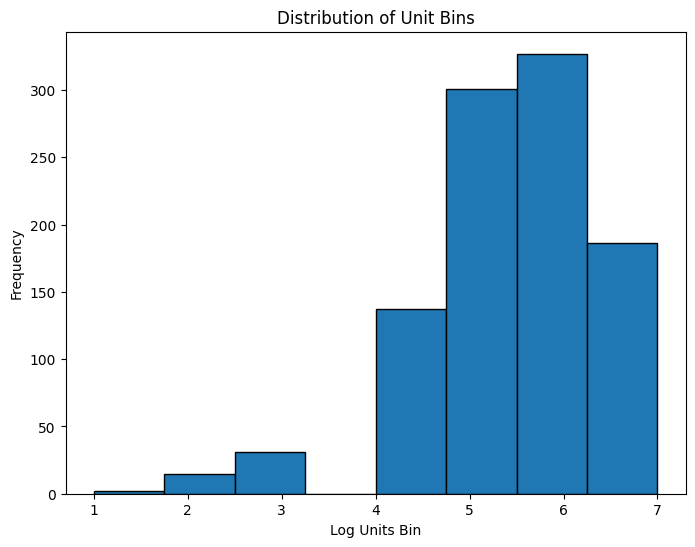

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(X_train_rfs['log_units_binned'], bins=8, edgecolor='k')
plt.xlabel('Log Units Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Unit Bins')

While this isn't as drastically skewed as the ALL fee, it still isn't great. The bins on the left are very sparse. We'll try equal frequency again

In [ ]:
X_train_rfs['equal_units_binned'], bin_edges = pd.qcut(X_train_rfs['units'], q=10, labels=False, retbins=True)

In [ ]:
pd.pivot_table(X_train_rfs, index='equal_units_binned', values='units', aggfunc=['min', 'max', 'count'])

,min,max,count
,units,units,units
equal_units_binned,,,
0.0,1.0,11.0,101
1.0,12.0,18.0,106
2.0,19.0,25.0,95
3.0,26.0,34.0,100
4.0,35.0,45.0,99
5.0,46.0,63.0,101
6.0,64.0,90.0,103
7.0,91.0,143.0,96


In [ ]:
X_test_rfs['equal_units_binned'] = pd.cut(X_test_rfs['units'], bins=bin_edges, labels=False, include_lowest=True)

In [ ]:
X_test_rfs['equal_units_binned'].value_counts(dropna=False)

,count
equal_units_binned,
NaN,32
5.0,28
7.0,26
8.0,26
2.0,26
0.0,25
9.0,23
1.0,23
4.0,23


In [ ]:
#drop the original units column
X_train_rfs = X_train_rfs.drop(['units', 'log_units', 'log_units_binned'], axis=1)
X_test_rfs = X_test_rfs.drop('units', axis=1)

Now we'll convert the binned units column dummies. Since get_dummies ignores nulls, when we convert this column the nulls will no longer be in our data

In [ ]:
X_train_rfs = pd.get_dummies(X_train_rfs, columns=['equal_units_binned'], prefix = 'unit_bin')
X_test_rfs = pd.get_dummies(X_test_rfs, columns=['equal_units_binned'], prefix = 'unit_bin')

In [ ]:
X_train_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 693 to 434
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              1096 non-null   int64  
 1   reminder              1096 non-null   int64  
 2   fee_probable          1096 non-null   float64
 3   sow_Class 1 RFS       1096 non-null   bool   
 4   sow_Class 2 RFS       1096 non-null   bool   
 5   sow_Class 3 RFS       1096 non-null   bool   
 6   sow_Update RFS        1096 non-null   bool   
 7   region_EO             1096 non-null   bool   
 8   region_GH             1096 non-null   bool   
 9   region_HUR            1096 non-null   bool   
 10  region_Other          1096 non-null   bool   
 11  region_PC             1096 non-null   bool   
 12  region_TOR            1096 non-null   bool   
 13  region_YR             1096 non-null   bool   
 14  building_commercial   1096 non-null   bool   
 15  building_highrise     109

In [ ]:
X_test_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 527 to 314
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prev_rfs              274 non-null    int64  
 1   reminder              274 non-null    int64  
 2   fee_probable          274 non-null    float64
 3   sow_Class 1 RFS       274 non-null    bool   
 4   sow_Class 2 RFS       274 non-null    bool   
 5   sow_Class 3 RFS       274 non-null    bool   
 6   sow_Update RFS        274 non-null    bool   
 7   region_EO             274 non-null    bool   
 8   region_GH             274 non-null    bool   
 9   region_HUR            274 non-null    bool   
 10  region_Other          274 non-null    bool   
 11  region_PC             274 non-null    bool   
 12  region_TOR            274 non-null    bool   
 13  region_YR             274 non-null    bool   
 14  building_commercial   274 non-null    bool   
 15  building_highrise     274 

**fee_probable**

We'll bin this one similar to how we binned it for the ALL model

In [ ]:
X_train_rfs['equal_fee_binned'], bin_edges = pd.qcut(X_train_rfs['fee_probable'], q=10, labels=False, retbins=True)

Text(0.5, 1.0, 'Distribution of Fee Bins')

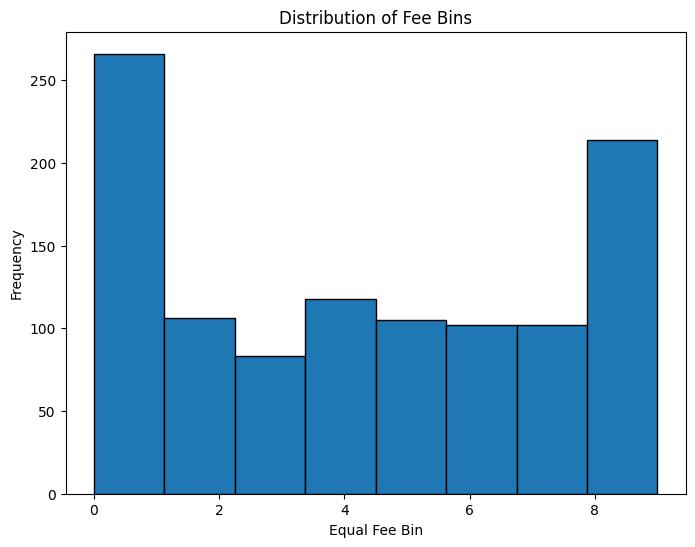

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(X_train_rfs['equal_fee_binned'], bins=8, edgecolor='k')
plt.xlabel('Equal Fee Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Fee Bins')

In [ ]:
pd.pivot_table(X_train_rfs, index='equal_fee_binned', values='fee_probable', aggfunc=['min', 'max', 'count'])

,min,max,count
,fee_probable,fee_probable,fee_probable
equal_fee_binned,,,
0,932.0,1995.0,121
1,2080.0,2295.0,145
2,2300.0,2495.0,106
3,2500.0,2695.0,83
4,2750.0,2995.0,118
5,3000.0,3295.0,105
6,3345.0,3695.0,102
7,3795.0,4195.0,102


In [ ]:
X_test_rfs['equal_fee_binned'] = pd.cut(X_test_rfs['fee_probable'], bins=bin_edges, labels=False, include_lowest=True)

In [ ]:
X_test_rfs['equal_fee_binned'].value_counts()

,count
equal_fee_binned,
1.0,40
4.0,36
0.0,27
2.0,26
6.0,26
9.0,25
8.0,24
3.0,23
7.0,23


In [ ]:
#Create dummies
X_train_rfs = pd.get_dummies(X_train_rfs, columns=['equal_fee_binned'], prefix = 'fee_bin')
X_test_rfs = pd.get_dummies(X_test_rfs, columns=['equal_fee_binned'], prefix = 'fee_bin')

In [ ]:
#drop fee_probable column
X_train_rfs = X_train_rfs.drop('fee_probable', axis=1)
X_test_rfs = X_test_rfs.drop('fee_probable', axis=1)

In [ ]:
X_train_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 693 to 434
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   prev_rfs              1096 non-null   int64
 1   reminder              1096 non-null   int64
 2   sow_Class 1 RFS       1096 non-null   bool 
 3   sow_Class 2 RFS       1096 non-null   bool 
 4   sow_Class 3 RFS       1096 non-null   bool 
 5   sow_Update RFS        1096 non-null   bool 
 6   region_EO             1096 non-null   bool 
 7   region_GH             1096 non-null   bool 
 8   region_HUR            1096 non-null   bool 
 9   region_Other          1096 non-null   bool 
 10  region_PC             1096 non-null   bool 
 11  region_TOR            1096 non-null   bool 
 12  region_YR             1096 non-null   bool 
 13  building_commercial   1096 non-null   bool 
 14  building_highrise     1096 non-null   bool 
 15  building_mixed_use    1096 non-null   bool 
 16  building_p

In [ ]:
X_test_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 527 to 314
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   prev_rfs              274 non-null    int64
 1   reminder              274 non-null    int64
 2   sow_Class 1 RFS       274 non-null    bool 
 3   sow_Class 2 RFS       274 non-null    bool 
 4   sow_Class 3 RFS       274 non-null    bool 
 5   sow_Update RFS        274 non-null    bool 
 6   region_EO             274 non-null    bool 
 7   region_GH             274 non-null    bool 
 8   region_HUR            274 non-null    bool 
 9   region_Other          274 non-null    bool 
 10  region_PC             274 non-null    bool 
 11  region_TOR            274 non-null    bool 
 12  region_YR             274 non-null    bool 
 13  building_commercial   274 non-null    bool 
 14  building_highrise     274 non-null    bool 
 15  building_mixed_use    274 non-null    bool 
 16  building_po

In [ ]:
#Rename X_train_rfs fee_bin_0 to fee_bin_0.0 and fee_bin_1 to fee_bin_1.0
X_train_rfs = X_train_rfs.rename(columns={'fee_bin_0': 'fee_bin_0.0',
                                          'fee_bin_1': 'fee_bin_1.0',
                                          'fee_bin_2': 'fee_bin_2.0',
                                          'fee_bin_3': 'fee_bin_3.0',
                                          'fee_bin_4': 'fee_bin_4.0',
                                          'fee_bin_5': 'fee_bin_5.0',
                                          'fee_bin_6': 'fee_bin_6.0',
                                          'fee_bin_7': 'fee_bin_7.0',
                                          'fee_bin_8': 'fee_bin_8.0',
                                          'fee_bin_9': 'fee_bin_9.0',
                                          })

In [ ]:
X_train_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 693 to 434
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   prev_rfs              1096 non-null   int64
 1   reminder              1096 non-null   int64
 2   sow_Class 1 RFS       1096 non-null   bool 
 3   sow_Class 2 RFS       1096 non-null   bool 
 4   sow_Class 3 RFS       1096 non-null   bool 
 5   sow_Update RFS        1096 non-null   bool 
 6   region_EO             1096 non-null   bool 
 7   region_GH             1096 non-null   bool 
 8   region_HUR            1096 non-null   bool 
 9   region_Other          1096 non-null   bool 
 10  region_PC             1096 non-null   bool 
 11  region_TOR            1096 non-null   bool 
 12  region_YR             1096 non-null   bool 
 13  building_commercial   1096 non-null   bool 
 14  building_highrise     1096 non-null   bool 
 15  building_mixed_use    1096 non-null   bool 
 16  building_p

In [ ]:
X_test_rfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 527 to 314
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   prev_rfs              274 non-null    int64
 1   reminder              274 non-null    int64
 2   sow_Class 1 RFS       274 non-null    bool 
 3   sow_Class 2 RFS       274 non-null    bool 
 4   sow_Class 3 RFS       274 non-null    bool 
 5   sow_Update RFS        274 non-null    bool 
 6   region_EO             274 non-null    bool 
 7   region_GH             274 non-null    bool 
 8   region_HUR            274 non-null    bool 
 9   region_Other          274 non-null    bool 
 10  region_PC             274 non-null    bool 
 11  region_TOR            274 non-null    bool 
 12  region_YR             274 non-null    bool 
 13  building_commercial   274 non-null    bool 
 14  building_highrise     274 non-null    bool 
 15  building_mixed_use    274 non-null    bool 
 16  building_po

These are done and ready to go!

# **Non-RFS Multicollinearity Check**

Before we finalize the data we'll check for correlation between features

In [ ]:
correlation_matrix = X_train_all.corr()

<Axes: >

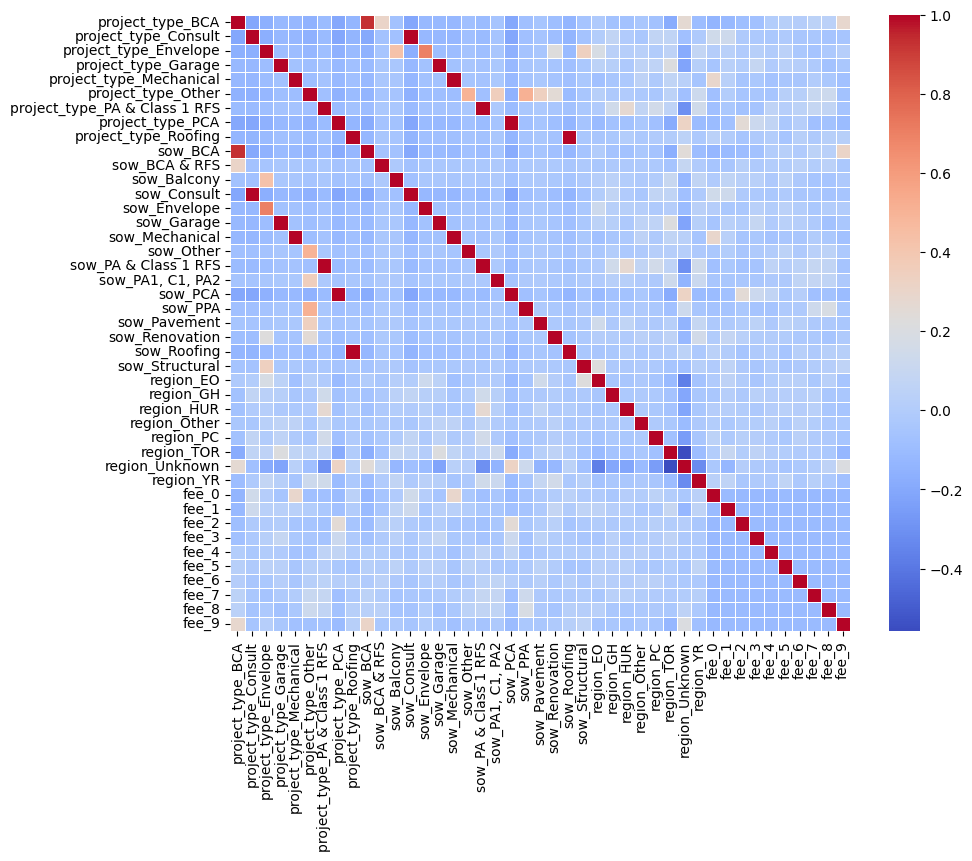

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

There is a lot of overlap between sow and project_type dummies. This isn't hugely surprising since project_type is an aggregated form of sow. We'll remove the ones that do not offer a unique aggregation

In [ ]:
X_train_all = X_train_all.drop(['project_type_BCA',
                                'project_type_Consult',
                                'project_type_Garage',
                                'project_type_Mechanical',
                                'project_type_Other',
                                'project_type_PCA',
                                'project_type_Roofing',
                                'project_type_Envelope'], axis=1)

In [ ]:
X_test_all = X_test_all.drop(['project_type_BCA',
                                'project_type_Consult',
                                'project_type_Garage',
                                'project_type_Mechanical',
                                'project_type_Other',
                                'project_type_PCA',
                                'project_type_Roofing',
                                'project_type_Envelope'], axis=1)

The relationship between region_Unknown and the PCA project type is interesting. While I can't think of a reason for this, there is no harm in removing region_Unknown

In [ ]:
X_train_all = X_train_all.drop('region_Unknown', axis=1)
X_test_all = X_test_all.drop('region_Unknown', axis=1)

In [ ]:
print(X_train_all.shape)

(1345, 34)


# **RFS Multicollinearity Check**

In [ ]:
correlation_matrix = X_train_rfs.corr()

<Axes: >

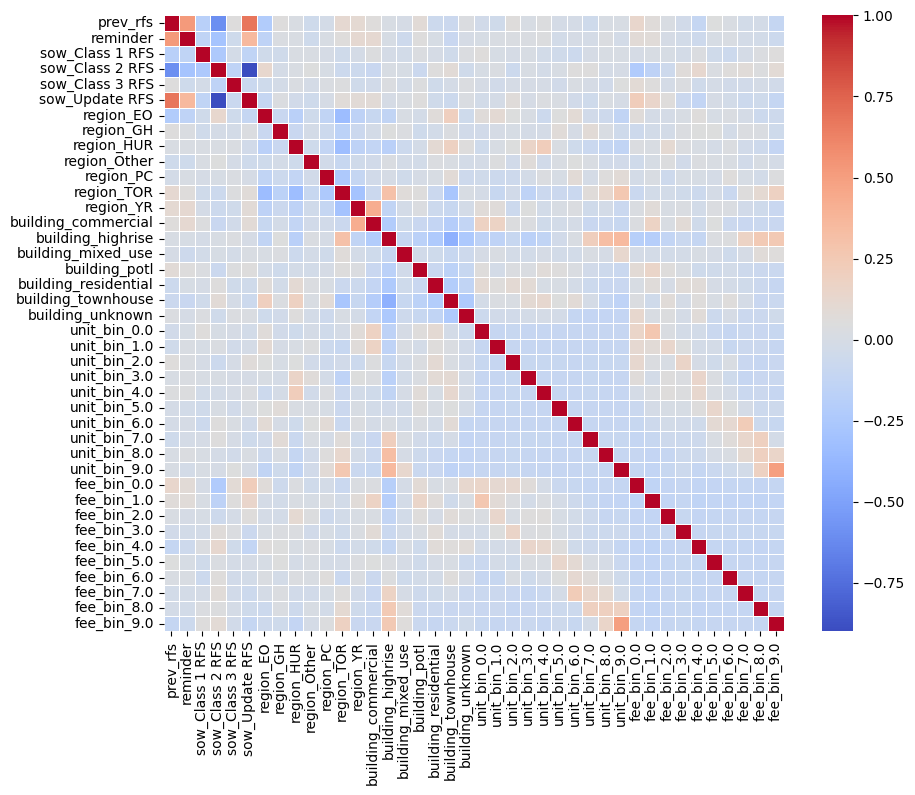

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

The main worry here is the prev_rfs feature, which is correlated with both reminder and sow_Update RFS. This isn't surprising, since they can usually only send reminders for clients that they did the previous rfs for. These reminder proposals are also usually Update RFS type.

In [ ]:
print('reminder and prev_rfs corr:', X_train_rfs['reminder'].corr(X_train_rfs['prev_rfs']))
print('Update RFS and prev_rfs corr:', X_train_rfs['sow_Update RFS'].corr(X_train_rfs['prev_rfs']))

reminder and prev_rfs corr: 0.5198887391674677
Update RFS and prev_rfs corr: 0.6763285672953366


The correlation isn't strong enough to require these features be removed. Each of these features adds unique value to the data, so I will keep them all as is

# **Data Exports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train_all.to_pickle('/content/drive/My Drive/shared_folder/X_train_all.pkl')
X_test_all.to_pickle('/content/drive/My Drive/shared_folder/X_test_all.pkl')
y_train_all.to_pickle('/content/drive/My Drive/shared_folder/y_train_all.pkl')
y_test_all.to_pickle('/content/drive/My Drive/shared_folder/y_test_all.pkl')

X_train_rfs.to_pickle('/content/drive/My Drive/shared_folder/X_train_rfs.pkl')
X_test_rfs.to_pickle('/content/drive/My Drive/shared_folder/X_test_rfs.pkl')
y_train_rfs.to_pickle('/content/drive/My Drive/shared_folder/y_train_rfs.pkl')
y_test_rfs.to_pickle('/content/drive/My Drive/shared_folder/y_test_rfs.pkl')

Download of final RFS and SOW datasets (pre train test split)

In [ ]:
#from google.colab import files
#rfs.to_csv('3.1 Final RFS Data.csv')
#files.download("3.1 Final RFS Data.csv")

#all.to_csv('3.2 Final All Data.csv')
#files.download("3.2 Final All Data.csv")